# NTT Signate Competition
## TODO
- Study and Visualize data
- Tried MFCC transformation (2D Conv)

In [44]:
import numpy as np
np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import librosa
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

# Read Tag

In [2]:
data_tag = pd.read_csv('data/class_train.tsv', sep='\t', header=None, names=['file_name', 'tag'])

In [4]:
data_tag.head(10)

,file_name,tag
0,0002f1cd968ca78ada9e1c7037224773,MA_CH
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD
2,0003b32f378b001f0f73bf0981da8773,MA_CH
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH
4,0005678b57ca265a65f8ef0cc7481277,MA_AD
5,00068ee0420a8dac9f7b51b1783b7f4b,FE_EL
6,0007a9416dd92cc01275be7e3aac6f9f,FE_CH
7,000841455294bab27f3ecc5e8829f2df,MA_AD
8,000ad3f1ea1fb1eafa92d9fa818c5122,MA_AD
9,000b1bbde96b2c541ee1721dfdda6d7a,FE_CH


In [3]:
# Preprocess the tag
gender_map = {'MA':0, 'FE':1}
age_map = {'CH':0, 'AD':1, 'EL':2}

data_tag['gender'] = data_tag['tag'].apply(lambda x: gender_map[x.split('_')[0]])
data_tag['age'] = data_tag['tag'].apply(lambda x: age_map[x.split('_')[1]])
data_tag['single_class'] = data_tag['tag'].apply(lambda x: gender_map[x.split('_')[0]] * 3 + age_map[x.split('_')[1]])

Text(0, 0.5, 'Number of Samples')

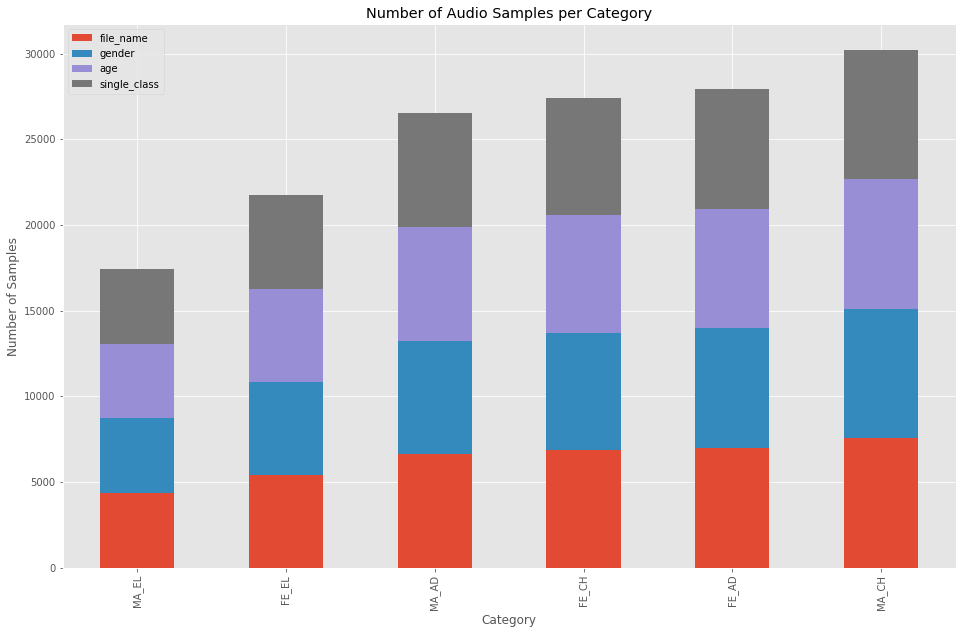

In [4]:
category_group = data_tag.groupby(['tag']).count()
plot = category_group.reindex(category_group['file_name'].sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples")

# Load sound

In [5]:
ROOT_PATH = 'data/train/'
sample_sound_list = os.listdir(ROOT_PATH)

In [6]:
import IPython.display as ipd  # To play sound in the notebook
fname = ROOT_PATH + sample_sound_list[2]   # Hi-hat
ipd.Audio(fname)

In [7]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname,)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  16000
Total samples (frames) =  (29760,)
[-20 -15  -5 ...  -3 -12 -20]


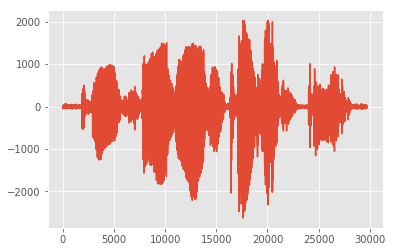

In [8]:
plt.plot(data)

(array([3.3558e+04, 3.7400e+03, 4.9300e+02, 1.1000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  5120.,  79600., 154080., 228560., 303040., 377520., 452000.,
        526480., 600960., 675440., 749920.]),
 <a list of 10 Patch objects>)

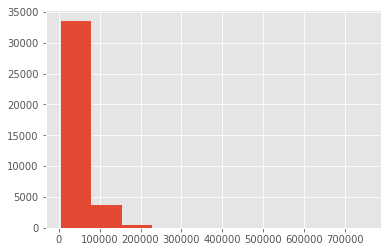

In [9]:
sound_lengths = [len(wavfile.read(ROOT_PATH + x)[1]) for x in sample_sound_list]
plt.hist(sound_lengths)

In [68]:
trim_silence_noise = lambda x: librosa.effects.trim(x.astype(np.float32), top_db=20)[0]
wave_data = []
tag_number = []
not_found = []
for row in data_tag.iterrows():
    file_name = ROOT_PATH + row[1]['file_name'] + '.wav'
    try:
        ori = wavfile.read(file_name)[1]
        trimmed = trim_silence_noise(ori)
        if len(trimmed) < 8000:
            wave_data.append(ori)
        else:
            wave_data.append(trimmed)
        tag_number.append(row[1]['single_class'])
    except FileNotFoundError:
        not_found.append(file_name)

In [69]:
lengths = [len(x) for x in wave_data]

In [70]:
min(lengths), max(lengths)

(5120, 749568)

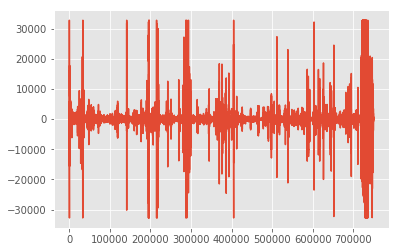

In [72]:
max_idx = np.argmax(lengths)
plt.plot(wave_data[max_idx])

In [75]:
data_tag.file_name.values[max_idx]

'3a5c89b172235ee5c45bcb9b5a134971'

In [74]:
ipd.Audio(ROOT_PATH + data_tag.file_name.values[max_idx] + '.wav')

In [11]:
tag_number = np.array(tag_number)

In [63]:
# Test sound cropping
SAMPLE = 'sample/'
sample_list = os.listdir(SAMPLE)
wav_list = []
for file in sample_list:
    wav_list.append(wavfile.read(SAMPLE + file)[1])

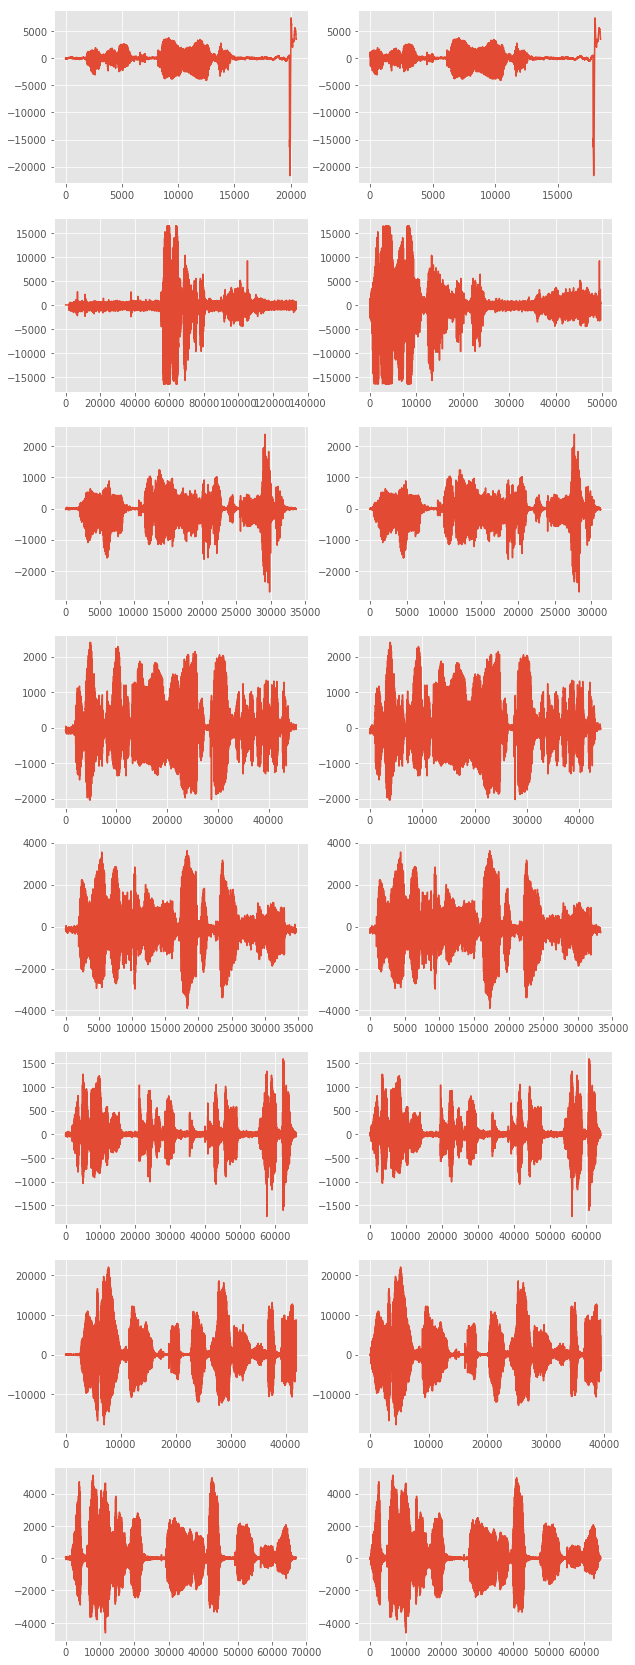

In [64]:
fig, axes = plt.subplots(len(sample_list), 2,figsize=(10,30))
for wav, row_axe in zip(wav_list, axes):
    cropped = librosa.effects.trim(wav.astype(np.float32), top_db=20)[0]
    row_axe[0].plot(wav)
    row_axe[1].plot(cropped)

In [49]:
librosa.effects.trim(to_crop.astype(np.float32))

(array([   0.,    0.,    0., ..., -142., -467., -487.], dtype=float32),
 array([  1024, 133440]))

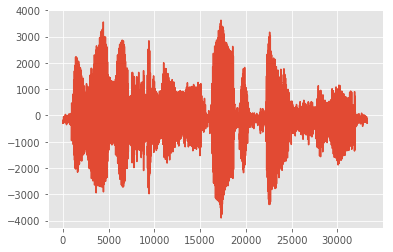

In [62]:
plt.plot(librosa.effects.trim(to_crop.astype(np.float32), top_db=20)[0])

(array([3.9200e+02, 3.4000e+01, 4.7000e+01, 4.2000e+01, 4.4000e+01,
        4.5000e+01, 5.1000e+01, 5.4000e+01, 6.0000e+01, 6.3000e+01,
        5.8000e+01, 4.7000e+01, 6.0000e+01, 6.4000e+01, 6.5000e+01,
        8.0000e+01, 7.1000e+01, 7.6000e+01, 6.9000e+01, 7.3000e+01,
        9.7000e+01, 9.1000e+01, 9.1000e+01, 1.1100e+02, 1.1200e+02,
        1.0100e+02, 1.3400e+02, 1.3600e+02, 1.2800e+02, 1.2600e+02,
        1.3200e+02, 1.4800e+02, 1.5700e+02, 1.7500e+02, 1.7800e+02,
        1.7400e+02, 2.2600e+02, 2.1800e+02, 2.8600e+02, 3.1900e+02,
        3.6700e+02, 5.0900e+02, 5.7800e+02, 8.3300e+02, 1.2330e+03,
        1.7670e+03, 3.3630e+03, 9.9250e+03, 2.4998e+04, 3.7131e+04,
        2.4068e+04, 8.8620e+03, 3.3330e+03, 2.0660e+03, 1.4770e+03,
        1.1550e+03, 9.0500e+02, 7.4400e+02, 5.4200e+02, 4.1400e+02,
        4.0200e+02, 3.3300e+02, 2.6900e+02, 2.3200e+02, 2.3800e+02,
        1.8900e+02, 1.7300e+02, 1.6300e+02, 1.7900e+02, 1.4200e+02,
        1.5700e+02, 1.4000e+02, 1.2000e+02, 1.07

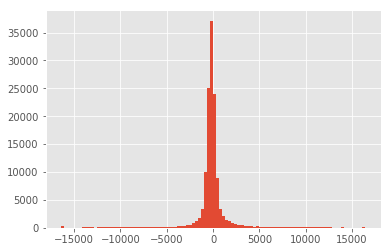

In [39]:
plt.hist(to_crop, bins=100)

In [37]:
np.max(np.abs(to_crop[:40000]))

2750

# Model & Data generator

In [12]:
import tensorflow as tf
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
from keras import backend as K

Using TensorFlow backend.


In [13]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=6,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [14]:
class DataGenerator(Sequence):
    def __init__(self, config, data, labels=None, 
                 batch_size=64, shuffle=True, preprocessing_fn=lambda x: x):
        self.config = config
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(len(self.data))
        else:
            self.indexes = np.arange(len(self.data))

    def __data_generation(self, indexes):
        cur_batch_size = len(indexes)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, idx in enumerate(indexes):
            data = self.data[idx].astype(np.float32)
            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = self.labels[indexes]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [15]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

In [17]:
config = Config(audio_duration=4)

In [30]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, padding="valid")(inp)
    x = Convolution1D(16, 9, padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, padding="valid")(x)
    x = Convolution1D(32, 3, padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, padding="valid")(x)
    x = Convolution1D(32, 3, padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, padding="valid")(x)
    x = Convolution1D(32, 3, padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, padding="valid")(x)
    x = Convolution1D(32, 3, padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, padding="valid")(x)
    x = Convolution1D(256, 3, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(1028)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

In [21]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)

In [22]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

In [23]:
eps = 1e-8
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    TP = K.sum(y_pred * y_true)
    precision = TP / (K.sum(y_pred)+eps)
    recall = TP / (K.sum(y_true)+eps)
    f1 = 2 * precision * recall / (eps+precision + recall)
    return f1


def f1_loss(y_true, y_pred):
    TP = K.sum(y_pred * y_true)
    precision = TP / (eps + K.sum(y_pred))
    recall = TP / (eps + K.sum(y_true))
    f1 = 2 * precision * recall / (eps + precision + recall)
    f1_loss = 1 - f1
    return f1_loss


def precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    TP = K.sum(y_pred * y_true)
    precision = TP / K.sum(y_pred)
    return precision


def recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    TP = K.sum(y_pred * y_true)
    recall = TP / K.sum(y_true)
    return recall

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(wave_data, tag_number, random_state=42)

In [31]:
K.clear_session()
config = Config(use_mfcc=False, n_mfcc=40)
dummy_model = get_1d_conv_model(config)
train_gen = DataGenerator(config, X_train, Y_train, preprocessing_fn=audio_norm)
val_gen = DataGenerator(config, X_val, Y_val, shuffle=False, preprocessing_fn=audio_norm)

In [35]:
len(sample_sound_list)

37806

In [32]:
opt = optimizers.Adam(config.learning_rate)
dummy_model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc', f1_score])

In [33]:
!mkdir logs
checkpoint = ModelCheckpoint('model/best_1d.h5', monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-8)
tb = TensorBoard(log_dir='logs/', write_graph=True)

callbacks_list = [checkpoint, early, tb, reduce_lr]

dummy_model.fit_generator(train_gen, validation_data=val_gen, callbacks=callbacks_list, epochs=config.max_epochs, workers=6, max_queue_size=20)

mkdir: cannot create directory ‘logs’: File exists
Epoch 1/50
444/444 [==============================] - 32s 72ms/step - loss: 1.5832 - acc: 0.3170 - f1_score: 0.1347 - val_loss: 1.4734 - val_acc: 0.3405 - val_f1_score: 0.2205

Epoch 00001: val_loss improved from inf to 1.47341, saving model to model/best_1d.h5
Epoch 2/50
444/444 [==============================] - 30s 67ms/step - loss: 1.2743 - acc: 0.4365 - f1_score: 0.2924 - val_loss: 1.3985 - val_acc: 0.4016 - val_f1_score: 0.3174

Epoch 00002: val_loss improved from 1.47341 to 1.39849, saving model to model/best_1d.h5
Epoch 3/50
444/444 [==============================] - 30s 67ms/step - loss: 1.1686 - acc: 0.4851 - f1_score: 0.3706 - val_loss: 1.2961 - val_acc: 0.4455 - val_f1_score: 0.4125

Epoch 00003: val_loss improved from 1.39849 to 1.29610, saving model to model/best_1d.h5
Epoch 4/50
444/444 [==============================] - 30s 67ms/step - loss: 1.0669 - acc: 0.5427 - f1_score: 0.4681 - val_loss: 1.1489 - val_acc: 0.5005 - 

In [ ]:
# Ensemble multiple prediction due to the randomness of the clipping


In [58]:
K.clear_session()
config = Config(use_mfcc=True, n_mfcc=40)
dummy_model = get_2d_conv_model(config)
train_gen = DataGenerator(config, X_train, Y_train, preprocessing_fn=audio_norm)
val_gen = DataGenerator(config, X_val, Y_val, shuffle=False, preprocessing_fn=audio_norm)

In [60]:
import librosa
opt = optimizers.Adam(config.learning_rate)
dummy_model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc', f1_score])

In [ ]:
!mkdir logs
checkpoint = ModelCheckpoint('model/best.h5', monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-8)
tb = TensorBoard(log_dir='logs/', write_graph=True)

callbacks_list = [checkpoint, early, tb, reduce_lr]

dummy_model.fit_generator(train_gen, validation_data=val_gen, callbacks=callbacks_list, epochs=config.max_epochs, workers=6, max_queue_size=20)

mkdir: cannot create directory ‘logs’: File exists
Epoch 1/50
444/444 [==============================] - 324s 731ms/step - loss: 0.4580 - acc: 0.8403 - f1_score: 0.8292 - val_loss: 0.5080 - val_acc: 0.8061 - val_f1_score: 0.8020

Epoch 00001: val_loss improved from inf to 0.50797, saving model to model/best.h5
Epoch 2/50
266/444 [================>.............] - ETA: 1:34 - loss: 0.3943 - acc: 0.8644 - f1_score: 0.8585

In [62]:
submission = pd.read_csv('data/class_train.tsv', sep='\t', header=None, names=['file_name', 'tag'])

In [63]:
submission.head()

,file_name,tag
0,0002f1cd968ca78ada9e1c7037224773,MA_CH
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD
2,0003b32f378b001f0f73bf0981da8773,MA_CH
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH
4,0005678b57ca265a65f8ef0cc7481277,MA_AD


In [66]:
TEST_PATH = 'data/test/'
file_list = os.listdir(TEST_PATH)

In [67]:
len(file_list)

17888

In [68]:
TEST_PATH = 'data/test/'
X_test = []
for file in file_list:
    file_name = TEST_PATH + file
    X_test.append(wavfile.read(file_name)[1])

In [69]:
test_gen = DataGenerator(config, X_test, shuffle=False, preprocessing_fn=audio_norm)

In [70]:
result = dummy_model.predict_generator(test_gen)

In [71]:
gender_map = {'MA':0, 'FE':1}
age_map = {'CH':0, 'AD':1, 'EL':2}
class_map = {0:'MA_CH', 1:'MA_AD', 2:'MA_EL', 3:'FE_CH', 4:'FE_AD', 5:'FE_EL'}

In [74]:
number_tags = np.argmax(result, axis=1)

In [75]:
submit_tag = [class_map[x] for x in number_tags]

In [76]:
df = pd.DataFrame(columns=['file_name', 'tags'])

In [77]:
df.file_name = [x.split('.')[0] for x in file_list]

In [78]:
df.tags = submit_tag

In [80]:
df.to_csv('data/prediction.tsv',sep='\t', header=False, index=False)